In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### Online and Offline Training data

In [2]:
df_on = pd.read_csv('DataSets/ccf_online_stage1_train.csv')
df_off = pd.read_csv('DataSets/ccf_offline_stage1_train.csv')

In [3]:
print("Online Training Data Sample\nShape:"+str(df_on.shape))
df_on.head()

Online Training Data Sample
Shape:(11429826, 7)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [4]:
print("Offline Training Data Sample\nShape:"+str(df_off.shape))
df_off.head()

Offline Training Data Sample
Shape:(1754884, 7)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


### TEST DATA (OFFLINE)

In [5]:
df_test = pd.read_csv('DataSets/ccf_offline_stage1_test_revised.csv')
print("Testing Data(Offline) Sample\nShape:"+str(df_test.shape))
df_test.head()

Testing Data(Offline) Sample
Shape:(113640, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708


### Converting Coupon to String type

In [6]:
print('Data type of coupon in different datasets\nOnline: '+str(df_on['Coupon_id'].dtypes)+'\nOffline: '+
      str(df_off['Coupon_id'].dtypes))
df_off['Coupon_id'] = [int(i) if i==i else i for i in df_off['Coupon_id']]
df_off['Coupon_id'] = df_off['Coupon_id'].apply(lambda x: "{:.0f}".
                                          format(x) if not pd.isnull(x) else x)

print('After conversion, data type of coupon in different datasets\nOnline: '+str(df_on['Coupon_id'].dtypes)+'\nOffline: '+
      str(df_off['Coupon_id'].dtypes))

Data type of coupon in different datasets
Online: object
Offline: float64
After conversion, data type of coupon in different datasets
Online: object
Offline: object


#### Converting Date to DateTime format

In [7]:
#Online Training Data
df_on['Date'] = pd.to_datetime(df_on["Date"],format='%Y%m%d')
df_on['Date_received'] = pd.to_datetime(df_on["Date_received"],format='%Y%m%d')

#Offline Training Data
df_off['Date'] = pd.to_datetime(df_off["Date"],format='%Y%m%d')
df_off['Date_received'] = pd.to_datetime(df_off["Date_received"],format='%Y%m%d')

### Removing Duplicates from Online and Offline Training Data

In [8]:
#Removing duplicates and giving frequency counts(Count) to each row

#Online
x = 'g8h.|$hTdo+jC9^@'    
df_on_unique = (df_on.fillna(x).groupby(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_on_unique["Date_received"]=pd.to_datetime(df_on_unique["Date_received"])
df_on_unique["Date"]=pd.to_datetime(df_on_unique["Date"])

print("Online Training Data Shape:"+str(df_on_unique.shape))

Online Training Data Shape:(5822543, 8)


In [9]:
#Offline
x = 'g8h.|$hTdo+jC9^@'   #garbage value for nan values 
df_off_unique = (df_off.fillna(x).groupby(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_off_unique["Date_received"]=pd.to_datetime(df_off_unique["Date_received"])
df_off_unique["Date"]=pd.to_datetime(df_off_unique["Date"])

print("Offline Training Data Shape:"+str(df_off_unique.shape))

Offline Training Data Shape:(1716991, 8)


#### Filling Nan for Distance (OFFLINE)

In [10]:
df_off_unique['Distance'].fillna(df_off_unique['Distance'].mean(), inplace=True)
df_off_unique['Distance'] = df_off_unique.Distance.astype(int)

### Converting Discount Ratio to Rate

In [11]:
#Funtion to convert discount ratio to discount rate
def convert_discount(discount):
    values = []
    for i in discount:
        if ':' in i:
            i = i.split(':')
            rate = round((int(i[0]) - int(i[1]))/int(i[0]),3)
            values.append([int(i[0]),int(i[1]),rate])
        elif '.' in i:
            i = float(i)
            x = 100*i
            values.append([100,int(100-x),i])
            
    discounts = dict(zip(discount,values))      
    return discounts
    

# convert_discount(list(df_of['Discount_rate']))

In [12]:
#ONLINE DATA
df_on_coupon = df_on_unique[(df_on_unique['Coupon_id'].isna()==False) & (df_on_unique['Coupon_id']!='fixed')]
discounts_online = list(df_on_coupon['Discount_rate'].unique())
df_on_coupon.loc[:,('Discount')] = df_on_coupon.loc[:,('Discount_rate')] 
df_on_coupon.loc[:,('Discount_rate')] = df_on_coupon[df_on_coupon['Coupon_id']!='fixed'].loc[:,('Discount')].map(convert_discount(discounts_online))
df_on_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_on_coupon['Discount_rate'].values.tolist(), index= df_on_coupon.index)
df_on_coupon.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,25104,2,100145044,"[100, 10, 0.9]",2016-03-31,NaT,1,100:10,100,10,0.900
14,209,27710,1,100081876,"[150, 10, 0.933]",2016-05-14,2016-05-14,1,150:10,150,10,0.933
44,236,53305,2,100075632,"[200, 10, 0.95]",2016-02-21,NaT,1,200:10,200,10,0.950
45,236,53305,2,100181719,"[50, 1, 0.98]",2016-02-21,NaT,1,50:1,50,1,0.980
46,236,53305,2,100214552,"[150, 5, 0.967]",2016-02-21,NaT,1,150:5,150,5,0.967


In [13]:
df_on_coupon = df_on_coupon.append(df_on_unique[df_on_unique['Coupon_id']=='fixed'], sort=False)
df_on_coupon.shape, df_on_unique[df_on_unique['Coupon_id'].isna()==False].shape

((759100, 12), (759100, 8))

In [14]:
#OFFLINE DATA
df_off_coupon = df_off_unique[(df_off_unique['Coupon_id'].isna()==False)].copy()
discounts_offline = list(df_off_coupon['Discount_rate'].unique())
df_off_coupon.loc[:,('Discount')] = df_off_coupon.loc[:,('Discount_rate')] 
df_off_coupon['Discount_rate'] = df_off_coupon['Discount'].map(convert_discount(discounts_offline))
df_off_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_off_coupon.Discount_rate.values.tolist(), index= df_off_coupon.index)
df_off_coupon.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,1433,8735,"[30, 5, 0.833]",10,2016-02-14,NaT,1,30:5,30,5,0.833
1,4,1469,2902,"[100, 5, 0.95]",10,2016-06-07,NaT,1,0.95,100,5,0.950
2,35,3381,11951,"[200, 20, 0.9]",0,2016-01-29,NaT,1,200:20,200,20,0.900
3,35,3381,11951,"[200, 20, 0.9]",0,2016-01-30,NaT,1,200:20,200,20,0.900
4,35,3381,1807,"[300, 30, 0.9]",0,2016-01-30,NaT,1,300:30,300,30,0.900


### Training Data (Online + Offline)

In [15]:
df_train = df_on_unique.append(df_off_unique, sort=False)
df_train = df_train.sort_values(by = ['User_id'] )
df_train = df_train.reset_index()
del df_train['index']
print("Training Data(Offline+Online) \nShape:"+str(df_train.shape))
df_train.head()

Training Data(Offline+Online) 
Shape:(7539534, 9)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN
1,4,1433,NaN,8735,30:5,2016-02-14,NaT,1,10.0
2,4,1469,NaN,2902,0.95,2016-06-07,NaT,1,10.0
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN
4,35,3381,NaN,11951,200:20,2016-01-30,NaT,1,0.0


In [16]:
df_train_coupon = df_on_coupon.append(df_off_coupon, sort=False)

## Merchant Anlaysis

### Merchant Distribution for Online, Offline and Test Datasets

In [17]:
merchant_off = set(df_off['Merchant_id'].unique())
merchant_on = set(df_on['Merchant_id'].unique())
merchant_test = set(df_test['Merchant_id'].unique())
len(merchant_off),len(merchant_on),len(merchant_test)

(8415, 7999, 1559)

In [18]:
merchant_on_off = merchant_on.intersection(merchant_off)
merchant_on_test = merchant_on.intersection(merchant_test)
merchant_test_off = merchant_test.intersection(merchant_off)
len(merchant_on_off), len(merchant_on_test), len(merchant_test_off)

(0, 0, 1558)

In [19]:
merchant_only_off = merchant_off - merchant_test
merchant_only_test = merchant_test - merchant_off
len(merchant_only_off),len(merchant_only_test)

(6857, 1)

<img src ="imgs/MerchantDistribution.png" width="60%">

 ### Merchant Redemption Score 

In [21]:
#Merchants in offline Dataset
merchant_redemption = pd.DataFrame(df_train_coupon.groupby(['Merchant_id'])['Coupon_id','Date']
                                           .count()).reset_index()
merchant_redemption.columns = ['Merchant_id','Merchant_Released', 'Merchant_Redeemed']
merchant_redemption['Merchant_Ratio'] = round(merchant_redemption['Merchant_Redeemed']
                                                      /merchant_redemption['Merchant_Released'],2)
merchant_redemption.head(5)

,Merchant_id,Merchant_Released,Merchant_Redeemed,Merchant_Ratio
0,2,7,0,0.00
1,3,10,1,0.10
2,4,7,5,0.71
3,5,28,3,0.11
4,8,2,0,0.00


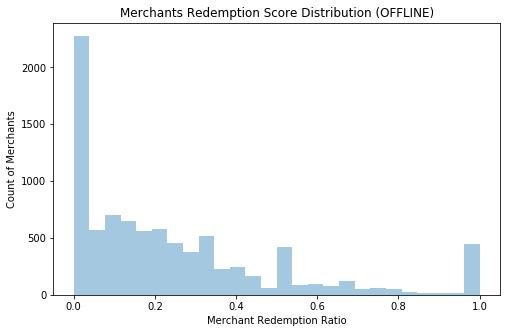

In [22]:
plt.figure(figsize=(8,5))
sns.distplot(merchant_redemption['Merchant_Ratio'],kde=False,bins=26)
plt.xlabel('Merchant Redemption Ratio')
plt.ylabel('Count of Merchants')
plt.title('Merchants Redemption Score Distribution (OFFLINE)')
plt.show()

### Merchant and Average Distance of its customers (OFFLINE)

In [23]:
merchant_distance = pd.DataFrame(df_train.groupby(['Merchant_id'])['Distance']
                                 .agg(['mean','count'])).reset_index()
merchant_distance.columns = ['Merchant_id','Merchant_AvgDistance','Count']
merchant_distance.head()

,Merchant_id,Merchant_AvgDistance,Count
0,1,0.000000,14
1,2,6.181818,11
2,3,5.000000,18
3,4,0.050000,40
4,5,1.531646,79


In [24]:
merchant_distance['Count'].describe()

count     16414.000000
mean        104.605276
std        1723.039636
min           0.000000
25%           0.000000
50%           1.000000
75%          19.000000
max      140811.000000
Name: Count, dtype: float64

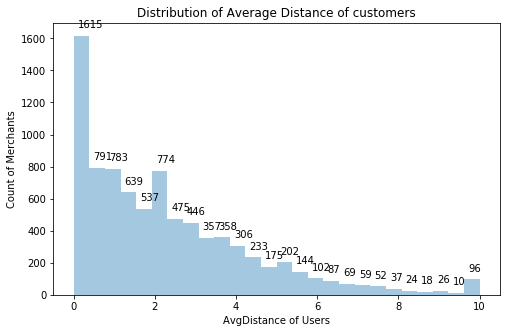

In [25]:
plt.figure(figsize=(8,5))
ax = sns.distplot(merchant_distance['Merchant_AvgDistance'],kde=False,bins=26)
plt.xlabel('AvgDistance of Users')
plt.ylabel('Count of Merchants')
plt.title('Distribution of Average Distance of customers')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

### Merchant and its Popularity
(based on number of visits of its customers)<br>
If visits > 40:
    then Merchant is Popular

In [26]:
df_purchase = df_train[df_train['Date'].isna()==False]
merchant_visits = pd.DataFrame(df_purchase.groupby(['Merchant_id','User_id','Date'])
                                   .size()).reset_index()

merchant_visits = pd.DataFrame(df_train.groupby(['Merchant_id'])['Date'].count()).reset_index()

merchant_visits = merchant_visits.rename(columns={"Date": "Merchant_Visits"})
merchant_visits.head()

,Merchant_id,Merchant_Visits
0,1,14
1,2,4
2,3,9
3,4,38
4,5,54


In [27]:
merchant_visits['Merchant_Visits'].describe()

count     16414.000000
mean        367.748446
std        1569.964930
min           0.000000
25%          14.000000
50%         117.000000
75%         288.000000
max      108796.000000
Name: Merchant_Visits, dtype: float64

In [28]:
merchant_visits['Merchant_Popular'] = [1 if x>40 else 0 
                                               for x in merchant_visits['Merchant_Visits']]
merchant_visits.sample(5)

,Merchant_id,Merchant_Visits,Merchant_Popular
6469,6803,285,1
10791,24809,214,1
12426,35012,1612,1
15881,56612,203,1
2314,2425,22,0


### Merchants and its Active duration

In [29]:
merchant_duration = df_train.copy()
merchant_duration['DateTrack'] = merchant_duration['Date']
merchant_duration.DateTrack.fillna(merchant_duration.Date_received, inplace=True)
merchant_duration.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance,DateTrack
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN,2016-03-31
1,4,1433,NaN,8735,30:5,2016-02-14,NaT,1,10.0,2016-02-14
2,4,1469,NaN,2902,0.95,2016-06-07,NaT,1,10.0,2016-06-07
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN,2016-03-08
4,35,3381,NaN,11951,200:20,2016-01-30,NaT,1,0.0,2016-01-30


In [30]:
merchant_duration_days = pd.DataFrame( merchant_duration.groupby(['Merchant_id'])['DateTrack']
                                     .agg(['min','max'])).reset_index()
merchant_duration_days.columns = ['Merchant_id','StartDate', 'EndDate']
merchant_duration_days['MerchantDuration'] = merchant_duration_days['EndDate']-merchant_duration_days['StartDate']
merchant_duration_days.head()

,Merchant_id,StartDate,EndDate,MerchantDuration
0,1,2016-01-15,2016-06-21,158 days
1,2,2016-05-15,2016-06-17,33 days
2,3,2016-04-24,2016-06-28,65 days
3,4,2016-02-18,2016-06-28,131 days
4,5,2016-01-01,2016-06-29,180 days


In [31]:
merchant_duration_days['MerchantDuration'] = merchant_duration_days['MerchantDuration'].dt.days.astype('str')
merchant_duration_days['MerchantDuration'] = pd.to_numeric(merchant_duration_days['MerchantDuration'],errors="coerce")
merchant_duration_days.head()

,Merchant_id,StartDate,EndDate,MerchantDuration
0,1,2016-01-15,2016-06-21,158
1,2,2016-05-15,2016-06-17,33
2,3,2016-04-24,2016-06-28,65
3,4,2016-02-18,2016-06-28,131
4,5,2016-01-01,2016-06-29,180


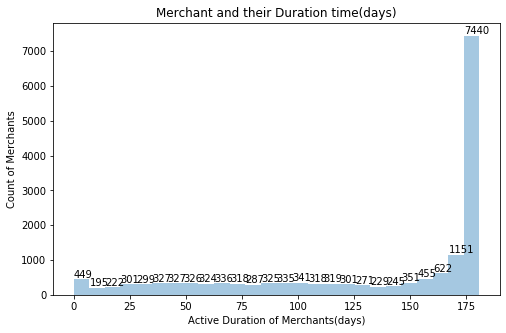

In [32]:
plt.figure(figsize=(8,5))
ax = sns.distplot(merchant_duration_days['MerchantDuration'],kde=False,bins=26)
plt.xlabel('Active Duration of Merchants(days)')
plt.ylabel('Count of Merchants')
plt.title('Merchant and their Duration time(days)')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

### Avg discount each merchant offers

In [33]:
#avg discounts each merchant offers
merchant_discounts_avg = pd.DataFrame(df_train_coupon.groupby(['Merchant_id'])['Rate'].mean())
merchant_discounts_avg.columns = ['Merchant_AvgRate']
merchant_discounts_avg = merchant_discounts_avg.reset_index()
merchant_discounts_avg.head()

,Merchant_id,Merchant_AvgRate
0,2,0.800
1,3,0.667
2,4,0.833
3,5,0.750
4,8,0.500


Text(0.5, 1.0, 'Merchant and Average Discount it offers')

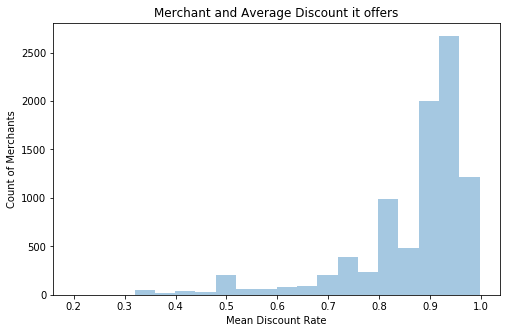

In [34]:
plt.figure(figsize=(8,5))
sns.distplot(merchant_discounts_avg['Merchant_AvgRate'],kde=False,bins=20)
plt.xlabel('Mean Discount Rate')
plt.ylabel('Count of Merchants')
plt.title('Merchant and Average Discount it offers')

### Number of different coupons released by different merchants

In [35]:
different_coupons = pd.DataFrame(df_train_coupon.groupby(['Merchant_id'])['Coupon_id'].nunique()).reset_index()
different_coupons.columns = ['Merchant_id','Different_Coupons']
different_coupons['Different_Coupons'].unique()

array([  1,   2,   4,   5,   3,   6,  12,  22,  11,   8,  19,   9,   7,
        39,  10,  14,  25,  13,  21,  15,  65,  24,  16,  31,  17,  32,
       162,  18,  56,  30,  28,  55,  27,  68,  20,  23,  54,  52, 176,
       236,  33,  60,  51,  45, 190,  85,  26,  72,  34,  46,  29,  47,
        43, 152,  38,  41,  64,  36, 135,  37,  48, 170, 125,  88, 114,
       105, 139,  66,  90, 102, 153, 175,  50,  80,  49,  69,  62,  42,
        35,  98, 137,  74,  89,  83,  57, 107,  40,  53,  58, 110,  44,
        75,  63])

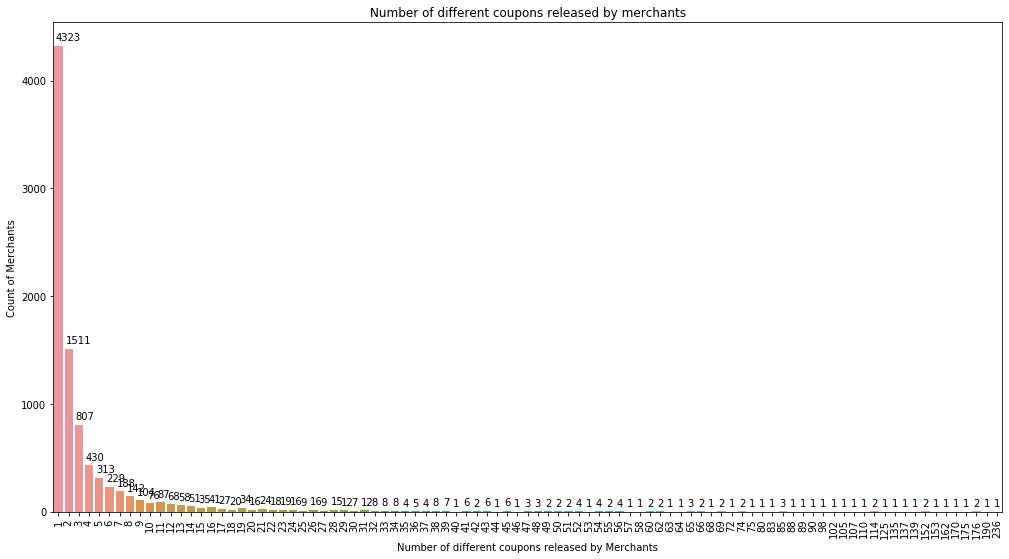

In [36]:
plt.figure(figsize=(17,9))
ax = sns.countplot(different_coupons['Different_Coupons'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.xlabel('Number of different coupons released by Merchants')
plt.ylabel('Count of Merchants')
plt.title('Number of different coupons released by merchants')
plt.show()

## Merchant and its last visiting window

In [37]:
merchant_days = df_train[df_train['Date'].isna()==False]
merchant_days['First_day'] = pd.to_datetime('20160101',format='%Y%m%d')
merchant_days['DayNum'] = merchant_days['Date'] - merchant_days['First_day'] 
merchant_days['DayNum'] = merchant_days['DayNum'].dt.days.astype('str')
merchant_days['DayNum'] = pd.to_numeric(merchant_days['DayNum'],errors="coerce") + 1
merchant_days.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance,First_day,DayNum
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN,2016-01-01,68
10,36,46701,0.0,NaN,NaN,NaT,2016-01-20,1,NaN,2016-01-01,20
12,64,11200,0.0,NaN,NaN,NaT,2016-05-26,1,NaN,2016-01-01,147
13,64,29214,0.0,NaN,NaN,NaT,2016-06-06,1,NaN,2016-01-01,158
14,64,29214,1.0,NaN,NaN,NaT,2016-06-06,1,NaN,2016-01-01,158


In [38]:
merchant_days = pd.DataFrame(merchant_days.groupby(['Merchant_id'])['DayNum']
                             .apply(list).reset_index(name='VisitList'))

In [39]:
merchant_days['VisitList'] = merchant_days['VisitList'].apply(lambda x : sorted(set(x)))
merchant_days

,Merchant_id,VisitList
0,1,"[15, 58, 61, 136, 140, 143, 144, 146, 150, 152..."
1,2,"[142, 153, 163, 169]"
2,3,"[115, 118, 120, 123, 126, 127, 132, 180]"
3,4,"[49, 50, 57, 59, 60, 61, 63, 64, 71, 91, 95, 1..."
4,5,"[1, 4, 6, 8, 10, 14, 24, 28, 30, 67, 71, 75, 8..."
...,...,...
16315,59912,"[4, 6, 10, 12, 16, 20, 48, 52, 53, 56, 59, 64,..."
16316,59913,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
16317,59914,"[1, 2, 4, 5, 6, 8, 10, 11, 12, 13, 17, 18, 22,..."
16318,59915,"[2, 3, 7, 13, 57, 61, 63, 64, 66, 67, 69, 70, ..."


## Merchant and its last Redemption window

In [40]:
merchant_red_days = df_train[df_train['Date'].isna()==False]
merchant_red_days['First_day'] = pd.to_datetime('20160101',format='%Y%m%d')
merchant_red_days['DayNum'] = merchant_red_days['Date'] - merchant_red_days['First_day'] 
merchant_red_days['DayNum'] = merchant_red_days['DayNum'].dt.days.astype('str')
merchant_red_days['DayNum'] = pd.to_numeric(merchant_red_days['DayNum'],errors="coerce") + 1
merchant_red_days.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance,First_day,DayNum
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN,2016-01-01,68
10,36,46701,0.0,NaN,NaN,NaT,2016-01-20,1,NaN,2016-01-01,20
12,64,11200,0.0,NaN,NaN,NaT,2016-05-26,1,NaN,2016-01-01,147
13,64,29214,0.0,NaN,NaN,NaT,2016-06-06,1,NaN,2016-01-01,158
14,64,29214,1.0,NaN,NaN,NaT,2016-06-06,1,NaN,2016-01-01,158


In [41]:
merchant_red_days = pd.DataFrame(merchant_red_days.groupby(['Merchant_id'])['DayNum'].apply(list).reset_index(name='MerchantRedemptionList'))

In [42]:
merchant_red_days['MerchantRedemptionList'] = merchant_red_days['MerchantRedemptionList'].apply(lambda x : sorted(set(x)))
merchant_red_days

,Merchant_id,MerchantRedemptionList
0,1,"[15, 58, 61, 136, 140, 143, 144, 146, 150, 152..."
1,2,"[142, 153, 163, 169]"
2,3,"[115, 118, 120, 123, 126, 127, 132, 180]"
3,4,"[49, 50, 57, 59, 60, 61, 63, 64, 71, 91, 95, 1..."
4,5,"[1, 4, 6, 8, 10, 14, 24, 28, 30, 67, 71, 75, 8..."
...,...,...
16315,59912,"[4, 6, 10, 12, 16, 20, 48, 52, 53, 56, 59, 64,..."
16316,59913,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
16317,59914,"[1, 2, 4, 5, 6, 8, 10, 11, 12, 13, 17, 18, 22,..."
16318,59915,"[2, 3, 7, 13, 57, 61, 63, 64, 66, 67, 69, 70, ..."


## Merchant and Average Daily New Users

In [43]:
merchant_dailyusers = pd.DataFrame(merchant_duration.groupby(['Merchant_id', 'Date'])['User_id'].nunique().reset_index(name='DailyUsers'))
merchant_avg_daily_users = pd.DataFrame(merchant_dailyusers.groupby(['Merchant_id'])['DailyUsers'].mean().reset_index(name='AvgDailyUsers'))
merchant_avg_daily_users.head()

,Merchant_id,AvgDailyUsers
0,1,1.076923
1,2,1.000000
2,3,1.125000
3,4,1.000000
4,5,1.227273


## Merchant and count of unique users 

In [44]:
merchant_unique_users = pd.DataFrame(df_train.groupby(['Merchant_id'])['User_id']
                                     .nunique().reset_index(name='UniqueUsersCount'))

## Merchant Level Features

In [45]:
merchants_level_data = pd.DataFrame(df_train['Merchant_id'].unique()).reset_index(drop=True)
merchants_level_data.columns = ['Merchant_id']
merchants_level_data.shape

(16414, 1)

In [46]:
#Adding Number of coupons redeemed and its redemption score for each merchant
merchants_level_data = pd.merge(merchants_level_data, merchant_redemption['Merchant_Redeemed'], how='left', left_on='Merchant_id', right_on=merchant_redemption['Merchant_id'])
merchants_level_data = pd.merge(merchants_level_data, merchant_redemption['Merchant_Ratio'], how='left', left_on='Merchant_id', right_on=merchant_redemption['Merchant_id'])

#Adding merchants and average distance of its users
merchants_level_data = pd.merge(merchants_level_data, merchant_distance['Merchant_AvgDistance'], how='left', left_on='Merchant_id', right_on=merchant_distance['Merchant_id'])

#Merchant is Popular(Visits>40) or Not Popular
merchants_level_data = pd.merge(merchants_level_data, merchant_visits['Merchant_Popular'], how='left', left_on='Merchant_id', right_on=merchant_visits['Merchant_id'])

#Adding merchants and average discount it offers
merchants_level_data = pd.merge(merchants_level_data, merchant_discounts_avg['Merchant_AvgRate'], how='left', left_on='Merchant_id', right_on=merchant_discounts_avg['Merchant_id'])

#Adding merchants and its duration
merchants_level_data = pd.merge(merchants_level_data, merchant_duration_days['MerchantDuration'], how='left', left_on='Merchant_id', right_on=merchant_duration_days['Merchant_id'])

#Daily new users (average) for a merchant
merchants_level_data = pd.merge(merchants_level_data, merchant_avg_daily_users, how='left', on='Merchant_id')

#Last Visiting window for the merchant
merchants_level_data = pd.merge(merchants_level_data,merchant_days,how='left',on='Merchant_id')
for row in merchants_level_data.loc[merchants_level_data.VisitList.isnull(), 'VisitList'].index:
    merchants_level_data.at[row, 'VisitList'] = []
    
# Merchant and count of unique users
merchants_level_data = pd.merge(merchants_level_data, merchant_unique_users, how='left', on='Merchant_id')
    
#Last Redemption window for the merchant
merchants_level_data = pd.merge(merchants_level_data,merchant_red_days,how='left',on='Merchant_id')
for row in merchants_level_data.loc[merchants_level_data.MerchantRedemptionList.isnull(), 'MerchantRedemptionList'].index:
    merchants_level_data.at[row, 'MerchantRedemptionList'] = []


In [47]:
merchants_level_data.isna().sum()

Merchant_id                  0
Merchant_Redeemed         7546
Merchant_Ratio            7546
Merchant_AvgDistance      7999
Merchant_Popular             0
Merchant_AvgRate          7584
MerchantDuration             0
AvgDailyUsers               94
VisitList                    0
UniqueUsersCount             0
MerchantRedemptionList       0
dtype: int64

In [48]:
for i in ['Merchant_Redeemed','Merchant_Ratio','Merchant_Ratio','AvgDailyUsers','Merchant_AvgRate']:
    merchants_level_data[i].fillna(0, inplace=True)

In [49]:
merchants_level_data.head()

,Merchant_id,Merchant_Redeemed,Merchant_Ratio,Merchant_AvgDistance,Merchant_Popular,Merchant_AvgRate,MerchantDuration,AvgDailyUsers,VisitList,UniqueUsersCount,MerchantRedemptionList
0,25104,3325.0,0.11,NaN,1,0.659866,181,114.525424,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",35887,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,1433,726.0,0.04,3.927992,1,0.810455,181,49.697802,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",19340,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,1469,675.0,0.05,2.617818,1,0.707819,181,74.527473,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",13702,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,45612,0.0,0.00,NaN,1,0.000000,181,11.351955,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1773,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,3381,2473.0,0.02,2.690394,1,0.866463,181,119.587912,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",108018,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [50]:
merchants_level_data.shape

(16414, 11)

In [51]:
merchants_level_data.to_csv('DataSets/DatasetsCreated/merchant_level.csv',index=False)

In [52]:
df_train['Merchant_id'].nunique()

16414